# Phase 3 - Vehicle Classification

This is an open ended phase. You must build a classifier for the Stanford Cars Dataset. You can use any techniques and knowledge from Phase 1 & 2 to aid you. The ultimate goal is to get as good performance as you can on the test set.

Please follow TA instructions in lab to learn how to access the data.

**Note**: You will need to achieve more than 80% accuracy on the test set to receive credit for Phase 3!

# Imports

Import all the libraries you need for your project

In [12]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io, transform 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

## 1) Load Dataset
The Stanford Dataset is not provided in ```torchvision.datasets```. You will need to create your inherit from ```Dataset``` class to load the dataset and overload the ```___init__()```, ```__len__()```, and ```__getitem__()``` functions.

You will find the following link useful to help create the dataset class: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

If you wish, you can create another method in the class: ```visualize()``` to help visualize the data. This is optional and will not be graded

In [13]:
# Referenced from above link
class CarDataSet(Dataset):

    def __init__(self, csv_file, root_dir, transform = None):
        self.label_frame = pd.read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.label_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir,
                                self.label_frame.iloc[idx, 0])
        image = io.imread(img_name)
        label = self.label_frame.iloc[idx, 5]

        image = Image.fromarray(image)
        image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'label': label}

        return sample

In [65]:
from torchvision import transforms
# Convert to 224x224 image
def get_image_transform(target_size=224):
    transform = transforms.Compose([
        transforms.Resize((target_size, target_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandAugment(),
        transforms.ToTensor()
    ])
    return transform

In [66]:
def test_image_transform(target_size=224):
    transform = transforms.Compose([
        transforms.Resize((target_size, target_size)),
        transforms.ToTensor()
    ])
    return transform

In [67]:
# Load the Data
train_data = CarDataSet(csv_file = "C:/Users/jones/OneDrive/Desktop/VS_Code/EEC174AY/lab3-student-gamers/stanford_cars_eec174/train_make.csv", 
                        root_dir = "C:/Users/jones/OneDrive/Desktop/VS_Code/EEC174AY/lab3-student-gamers/stanford_cars_eec174/images/train",
                        transform = get_image_transform(target_size=224))
test_data = CarDataSet(csv_file = "C:/Users/jones/OneDrive/Desktop/VS_Code/EEC174AY/lab3-student-gamers/stanford_cars_eec174/val_make.csv", 
                        root_dir = "C:/Users/jones/OneDrive/Desktop/VS_Code/EEC174AY/lab3-student-gamers/stanford_cars_eec174/images/val",
                        transform = test_image_transform(target_size=224))

# Batch Size
batch_size = 16

# Import to Dataloaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                              batch_size = batch_size,
                                              shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                              batch_size = batch_size,
                                              shuffle = False)

In [68]:
names = pd.read_csv(r'C:\Users\jones\OneDrive\Desktop\VS_Code\EEC174AY\lab3-student-gamers\stanford_cars_eec174\names_make.txt', header=None)

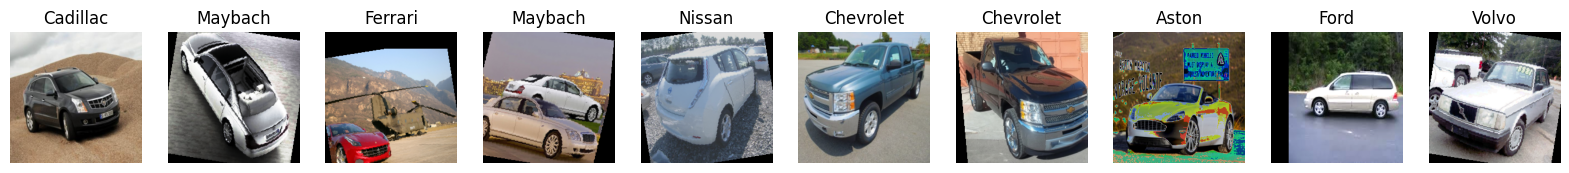

In [89]:
def im_show(loader):
    fig, ax = plt.subplots(1, 10, figsize=(20, 20))

    for i in range(10):
        dataiter = iter(loader)
        image = next(dataiter)
        pic = image['image']
        label = image['label']
        npimg = utils.make_grid(pic[0]).numpy()
        ax[i].axis('off')
        ax[i].imshow(np.transpose(npimg, (1, 2, 0)))
        ax[i].set_title(names[0][label[0].item()-1])
        
im_show(train_loader)

## 2) Define your Model Architecture

It is up to you to decide which model you use. You can create yor own CNN or use transfer learning.

In [20]:
# Model definition
# Instantiate Pretrained ResNet18
resnet34 = models.resnet34(pretrained = True)

# We have 49 Classes
num_classes = len(names)+1
print(len(names))

# Modify final layer
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)

# Load onto GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet34.to(device)

c:\Users\jones\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jones\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


49


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [63]:
# Loss Function
loss_function = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(resnet34.parameters(), lr=3e-4)

## 3) Define Loss function and Optimizer

You chose the loss function and optimizer.

## 4) Train your Network

In [23]:
import time

# Do I need 2D array to store information on epoc and corresponding train/validation arrays?

def train(model, loss_fn, optimizer, train_loader, batch_size, num_epochs, device):
    acc_arr_train, acc_arr_valid, loss_avg_valid, loss_avg_train, loss_arr_train = [], [], [], [], []

    # Iterate through all Epochs
    for epoch in range(num_epochs):
      start_epoc_time = time.perf_counter()
      for i, data in enumerate(train_loader):
        # load images/labels
        images, labels = data['image'].cuda(), data['label'].cuda()
        
        optimizer.zero_grad()                     # Zero collected gradients at each step
        outputs = model(images)                   # Forward Propagate
        loss = loss_fn(outputs, labels)           # Calculate train Loss
        loss.backward()                           # Back propagate
        optimizer.step()                          # Update weights
        loss_arr_train.append(loss.item())        # Store Loss of current iteration
        
        # Print statistics on every 100th iteration
        if (i+1) % 100 == 0:
          # Average the past 100 iterations and append that Loss value
          window_train = loss_arr_train[(len(loss_arr_train)-100):]
          avg_train =  sum(window_train) / 100
          avg_valid, _ = test_accuracy(model, test_loader, 0, loss_function, device)
          loss_avg_valid.append(avg_valid)
          loss_avg_train.append(avg_train)
          

          print("""Epoch [%d/%d], Step [%d/%d], Train Loss: %.4f, Val Loss: %.4f"""
                %(epoch+1, num_epochs, i+1,
                len(train_data) // batch_size, loss.item(), avg_valid)) 

          scheduler.step(avg_valid)

      time_epoc_stop = time.perf_counter() # Stop the timer

      # Average of train and validation accuracies:
      _, train_acc = test_accuracy(model, train_loader, 0, loss_function, None)
      _, test_acc = test_accuracy(model, test_loader, 0, loss_function, None)

      acc_arr_train.append(train_acc)
      acc_arr_valid.append(test_acc)

      # Print epoc, time taken for epoc, train accuracy, valid accuracy
      print("""Epoch [%d/%d], Time Taken: %.4f, Train Acc: %.4f, Valid Acc: %.4f"""
            % (epoch + 1, num_epochs, time_epoc_stop - start_epoc_time,
             train_acc, test_acc))
      print("--------------------------------------------------------------")

    return acc_arr_train, acc_arr_valid, loss_avg_train, loss_avg_valid

def test_accuracy(model, test_loader, input_size, loss_fn, device):
    model.to(device)
    correct = 0
    total = 0
    loss_valid, loss_train = [], []
    with torch.no_grad():
        for test_data in test_loader:
            images, labels = test_data['image'].cuda(), test_data['label'].cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            valid_loss = loss_fn(outputs, labels)
            loss_valid.append(valid_loss.item())
    avg_valid_loss = sum(loss_valid) / len(loss_valid)
    return avg_valid_loss, (100 * correct / total)

# Plot Learning Curves
def plot_learning_curve(train_loss, valid_loss, title):
    plt.figure(0)
    plt.plot(range(0, len(train_loss*100), 100), train_loss, label = "Train Loss")
    plt.plot(range(0, len(valid_loss*100), 100), valid_loss, label = "Validation Loss")
    plt.legend()
    plt.title(title)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

In [90]:
# Define Parameters
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

num_epochs = 20

# Train Model
acc_arr_train, acc_arr_valid, loss_avg_train, loss_avg_valid = train(resnet34, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

# Evaluate on Test Set
test_accuracy(model=resnet34, test_loader=test_loader, input_size=0, loss_fn = loss_function, device=device)

Epoch [1/20], Step [100/509], Train Loss: 0.2868, Val Loss: 0.6265
Epoch [1/20], Step [200/509], Train Loss: 0.0986, Val Loss: 0.6172
Epoch [1/20], Step [300/509], Train Loss: 0.6094, Val Loss: 0.6405
Epoch [1/20], Step [400/509], Train Loss: 0.4389, Val Loss: 0.6274
Epoch [1/20], Step [500/509], Train Loss: 0.2409, Val Loss: 0.6071
Epoch [1/20], Time Taken: 137.3188, Train Acc: 91.3065, Valid Acc: 83.8308
--------------------------------------------------------------
Epoch [2/20], Step [100/509], Train Loss: 0.1964, Val Loss: 0.5222
Epoch [2/20], Step [200/509], Train Loss: 0.8448, Val Loss: 0.6227
Epoch [2/20], Step [300/509], Train Loss: 0.1789, Val Loss: 0.5730
Epoch [2/20], Step [400/509], Train Loss: 0.0583, Val Loss: 0.5535
Epoch [2/20], Step [500/509], Train Loss: 0.4355, Val Loss: 0.5667
Epoch [2/20], Time Taken: 136.1825, Train Acc: 92.7922, Valid Acc: 83.9138
--------------------------------------------------------------
Epoch [3/20], Step [100/509], Train Loss: 0.3987, Val 

(0.32810409516342826, 91.08623548922057)

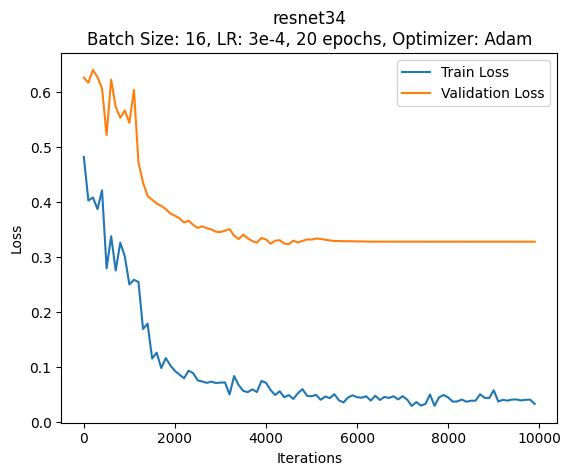

In [91]:
plot_learning_curve(loss_avg_train, loss_avg_valid, "resnet34\nBatch Size: 16, LR: 3e-4, 20 epochs, Optimizer: Adam")

In [93]:
torch.save(resnet34, r"C:\Users\jones\OneDrive\Desktop\VS_Code\EEC174AY\lab3-student-gamers\model.pth")

## 4) Evaluate (on Test Set)

In [ ]:
# Test Accuracy
_, acc = test_accuracy(model=resnet34, test_loader=test_loader, input_size=0, loss_fn = loss_function, device=device)
print("Model Validation Accuracy:", acc)

## 5) Report

Please write a report discussing all your choices and procedure to implement your vehicle classifier. In your report, include all your choices (i.e. hyperparameters, lr, models, loss, optimizer) and explain why you made those choices to achieve your performance. Your report must be thorough and comprehensive, please discuss fully how you were able to obtain a high performance.

From the previous phase, we found optimal hyperparameters of learning rate = 3e-4 and optimizer = Adam gave the best performance. In this model we added a scheduler to adjust the learning rate for when the model was reaching close to its optimal values. We also changed the batch size to 16 since the images were much larger and the dataset was smaller. We decided the resize all of the images as well to 224x224 to match the expected size of images input to the resnet model. We did a lot of trial and error in changing around the optimizer, learning rate, batch size, model, and different types of image processing before achieving our 90% accuracy using (lr=3e-4, optimizer = Adam, batch size = 16, scheduler, Random training data augment, model = resnet34)

We searched the pytorch models for a model similar to our car classification task and found resnet34 which has more layers than resnet18 but isn't so large as to take an unreasonable amount of time to train. Overfitting was a big problem for this model as the training accuracy would consistently go to nearly 100% with enough epochs, but the validation accuracy would remain in the 80% range. To somewhat compensate for this, we added a random augmentation to the training images so that the model would be forced to generalize more instead of essentially memorizing the pictures in the training set. This improved the accuracy from the low 80% to 90% range. 

We saved our model as model.pth

To test our model, input the paths for the test labels and test images below and run the below cell blocks

In [94]:
path_to_test_labels = r'PATH_TO_TEST_LABELS'

path_to_test_images = r'PATH_TO_TEST_IMAGES'

path_to_model = r'PATH_TO_MODEL'

model = torch.load(path_to_model)

In [95]:
class CarDataSet(Dataset):

    def __init__(self, csv_file, root_dir, transform = None):
        self.label_frame = pd.read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.label_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir,
                                self.label_frame.iloc[idx, 0])
        image = io.imread(img_name)
        label = self.label_frame.iloc[idx, 5]

        image = Image.fromarray(image)
        image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'label': label}

        return sample

In [96]:
def test_image_transform(target_size=224):
    transform = transforms.Compose([
        transforms.Resize((target_size, target_size)),
        transforms.ToTensor()
    ])
    return transform

In [97]:
test_data = CarDataSet(csv_file = path_to_test_labels, 
                        root_dir = path_to_test_images,
                        transform = test_image_transform(target_size=224))

batch_size = 16

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                              batch_size = batch_size,
                                              shuffle = False)

In [98]:
def test_accuracy(model, test_loader, device):
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for test_data in test_loader:
            images, labels = test_data['image'].cuda(), test_data['label'].cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy: %d %%' % (100 * correct / total))

In [100]:
test_accuracy(model=model, test_loader=test_loader, device=device)

Accuracy: 91 %
